# Probabilistic Programming in Pyro
LEARN HOW TO CODE A PAPER WITH STATE OF THE ART FRAMEWORKS <br>
NIPS 2017

## Pyro Installation Instructions 

First install [PyTorch](http://pytorch.org).

Install via pip:

Python 2.7.*:
```python
pip install pyro-ppl
```

Python 3.5:

```python
pip3 install pyro-ppl
```

Install from source:

```python
git clone git@github.com:uber/pyro.git
cd pyro
pip install .
```

This particular notebook can be found on the nips-2017 branch of the [GitHub repo](https://github.com/uber/pyro) in the examples/nips2017 directory.

## First steps

Let's start with some imports

In [1]:
import torch
from torch.autograd import Variable

import pyro
import pyro.distributions as dist

Let's draw a sample from a unit normal distribution:

In [2]:
mu = Variable(torch.zeros(1))   # mean zero
sigma = Variable(torch.ones(1)) # unit variance
x = dist.normal(mu, sigma)      # x is a sample from N(0,1)
print(x)

Variable containing:
1.00000e-02 *
 -7.5665
[torch.FloatTensor of size 1]



We can compute the log pdf of the sample as follows

In [3]:
dist.normal.log_pdf(x, mu, sigma)

Variable containing:
-0.9218
[torch.FloatTensor of size 1]

We can also declare mu as a named parameter:

In [4]:
mu = pyro.param("mu", Variable(torch.zeros(1), requires_grad=True))
print(mu)

Variable containing:
 0
[torch.FloatTensor of size 1]



## The VAE

#### The Model
First we define our decoder network

In [5]:
import torch.nn as nn

z_dim=20
hidden_dim=100

nn_decoder = nn.Sequential(
    nn.Linear(z_dim, hidden_dim), 
    nn.Softplus(), 
    nn.Linear(hidden_dim, 784), 
    nn.Sigmoid()
)

Now we can define our (unconditioned) generative model:

In [6]:
# import helper functions for Variables with requires_grad=False
from pyro.util import ng_zeros, ng_ones 

def model(batch_size):
    # register the decoder with Pyro (in particular all its parameters)
    pyro.module("decoder", nn_decoder)  
    # sample the latent code z
    z = pyro.sample("z", dist.normal,   
                    ng_zeros(batch_size, z_dim), 
                    ng_ones(batch_size, z_dim))
    # decode z into bernoulli probabilities
    bern_prob = nn_decoder(z)          
    # return the mini-batch of sampled images
    return pyro.sample("x", dist.bernoulli, bern_prob) 

We can use `pyro.condition` to condition `model` on data `x`:

In [7]:
def conditioned_model(x):
    return pyro.condition(model, data={"x": x})(x.size(0))

#### The guide

In order to do inference, we need to define a guide (a.k.a. an inference network). First we define the encoder network. Let's go ahead and define it explicitly instead of using `nn.Sequential`:

In [8]:
class Encoder(nn.Module):
    def __init__(self, z_dim=20, hidden_dim=100):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearity
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        # define the forward computation on the image x
        # first compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_mu = self.fc21(hidden)
        z_sigma = torch.exp(self.fc22(hidden))
        return z_mu, z_sigma

Now we can define the guide:

In [9]:
nn_encoder = Encoder()

def vae_guide(x):
    # register the encoder with Pyro
    pyro.module("encoder", nn_encoder)
    # encode the mini-batch of images x
    mu_z, sig_z = nn_encoder(x)
    # sample and return the latent code z
    return pyro.sample("z", dist.normal, mu_z, sig_z)

#### Inference
Now we're ready to do inference. First we setup our optimizer

In [10]:
from pyro.optim import Adam
optimizer = Adam({"lr": 1.0e-3})

Now we setup the `SVI` inference algorithm, which we will use to take gradient steps on the ELBO objective function. Note that `conditioned_model` and `vae_guide` both have the same call signature (namely they taken in a mini-batch of images `x`).

In [11]:
from pyro.infer import SVI
svi = SVI(conditioned_model, vae_guide, optimizer, loss="ELBO")

Let's setup a basic training loop. First we setup the data loader:

In [12]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

batch_size=250
trans = transforms.ToTensor()
train_set = dset.MNIST(root='./mnist_data', train=True, 
                       transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size,
                                           shuffle=True)

Let's do 5 epochs of training and report the ELBO averaged per data point for each epoch

In [13]:
num_epochs = 5

for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # wrap the mini-batch of images in a PyTorch Variable
        x = Variable(x.view(-1, 784))
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # report training diagnostics
    normalizer = len(train_loader.dataset)
    print("[epoch %03d]  average training ELBO: %.4f" % (epoch, -epoch_loss / normalizer))

[epoch 000]  average training ELBO: -222.1838
[epoch 001]  average training ELBO: -162.3965
[epoch 002]  average training ELBO: -145.9005
[epoch 003]  average training ELBO: -135.8887
[epoch 004]  average training ELBO: -129.2965


So much for the VAE. For a more fleshed out implementation and some results please see the [tutorial](http://pyro.ai/examples/vae.html).

## Recursion with random control flow

Let's define the geometric distribution in terms of draws from a bernoulli distribution:

In [14]:
def geom(num_trials=0, bern_prob=0.5):
    p = Variable(torch.Tensor([bern_prob]))
    x = pyro.sample('x{}'.format(num_trials), dist.bernoulli, p)
    if x.data[0] == 1:
        return num_trials  # terminate recursion
    else:
        return geom(num_trials + 1, bern_prob)  # continue recursion

# let's draw 15 samples 
for _ in range(15):
    print("%d  " % geom()),

1   0   0   0   0   0   0   0   2   0   0   0   3   1   0  


Note that the random variables in `geom` are generated dynamically and that different calls to `geom` can have different numbers of random variables. Also note that we take care to assign unique names to each dynamically generated random variable.

If we crank down the bernoulli probability (so that the recursion tends to terminate after a larger number of steps) we get a geometric distribution with more of a tail:

In [15]:
for _ in range(15):
    print("%d  " % geom(bern_prob=0.1)),

3   4   23   0   3   11   17   1   4   9   1   14   1   4   7  


## AIR

#### The prior

Let's build on `geom()` above to construct a recursive prior over images. First we need a prior over a single object in an image. Just like for the VAE, this prior is going to involve a decoder network. So we define that first:

In [16]:
from torch.nn.functional import relu, sigmoid, grid_sample, affine_grid

z_dim=50

# this decodes latents z into (bernoulli pixel intensities for)
# 20x20 sized objects
class Decoder(nn.Module):
    def __init__(self, hidden_dim=200):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(z_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, 20*20)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decoder = Decoder()

Now we build the prior over a single object. Note that this prior uses (differentiable) spatial transformers to position the sampled object within the image. Most of the complexity in this code snippet is on the spatial transformer side.

In [17]:
# define the prior probabilities for our random variables
z_where_prior_mu = Variable(torch.Tensor([3, 0, 0]))
z_where_prior_sigma = Variable(torch.Tensor([0.1, 1, 1]))
z_what_prior_mu = ng_zeros(50)
z_what_prior_sigma = ng_ones(50)

def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 
    # 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = Variable(torch.LongTensor([1, 0, 2, 0, 1, 3]))
    out = torch.cat((ng_zeros([1, 1]).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

# takes the object generated by the decoder and places it 
# within a larger image with the desired pose
def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

def prior_step(t):
    # Sample object pose. This is a 3-dimensional vector representing 
    # x,y position and size.
    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal,
                          z_where_prior_mu,
                          z_where_prior_sigma,
                          batch_size=1)

    # Sample object code. This is a 50-dimensional vector.
    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal,
                         z_what_prior_mu,
                         z_what_prior_sigma,
                         batch_size=1)

    # Map code to pixel space using the neural network.
    y_att = decoder(z_what)

    # Position/scale object within larger image.
    y = object_to_image(z_where, y_att)

    return y

Let's draw a few samples from the object prior to see how this looks.

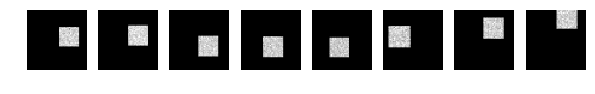

In [18]:
from matplotlib import pyplot as plt

samples = [prior_step(0)[0] for _ in range(8)]

def show_images(samples):
    plt.rcParams.update({'figure.figsize': [10, 1.6] })
    f, axarr = plt.subplots(1, len(samples))

    for i, img in enumerate(samples):
        axarr[i].imshow(img.data.numpy(), cmap='gray')
        axarr[i].axis('off')

    plt.show()
    
show_images(samples)

Now we can use `prior_step` to define a recursive prior over images:

In [19]:
def geom_image_prior(x, step=0):
    p = Variable(torch.Tensor([0.4]))
    i = pyro.sample('i{}'.format(step), dist.bernoulli, p)
    if i.data[0] == 1:
        return x
    else:
        # add sampled object to canvas
        x = x + prior_step(step)  
        return geom_image_prior(x, step + 1)

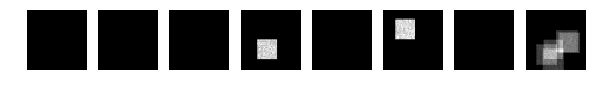

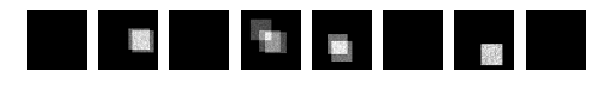

In [20]:
x_empty = ng_zeros(1, 50, 50)
samples = [geom_image_prior(x_empty)[0] for _ in range(16)]
show_images(samples[0:8])
show_images(samples[8:16])

We see that the images sampled from the prior have a variable number of objects, with the objects placed throughout the image. The objects are also allowed to stack (so that pixel intensities can exceed 1).

#### Reconstructing images with the trained model/guide pair

Let's take advantage of the fact that someone has trained the model and guide for us and see what we can do. One nice thing about amortized variational inference is that it allows us to use the guide (i.e. the inference network) to make quick test time predictions. Let's see how that goes in Pyro. First some imports:

In [21]:
# this is the dataset we used for training
from observations import multi_mnist 
import numpy as np

import pyro.poutine as poutine

from air import AIR, latents_to_tensor
from viz import draw_many, tensor_to_objs, arr2img

Next we load and preprocess the test set:

In [22]:
def load_data():
    inpath = './multi_mnist_data'
    _, (X_np, Y) = multi_mnist(inpath, max_digits=2, canvas_size=50, seed=42)
    X_np = X_np.astype(np.float32)
    X_np /= 255.0
    X = Variable(torch.from_numpy(X_np))
    return X

X = load_data()

Next we instantiate an instance of the AIR `nn.module`, which contains both the model and the guide (and all the associated neural networks). Here we take care to use same hyperparameters that were used during training. We also load the learned model and guide parameters from disk.

In [23]:
air = AIR(
    num_steps=3,
    x_size=50,
    z_what_size=50,
    window_size=28,
    encoder_net=[200],
    decoder_net=[200],
    predict_net=[200],
    bl_predict_net=[200],
    rnn_hidden_size=256,
    decoder_output_use_sigmoid=True,
    decoder_output_bias=-2,
    likelihood_sd=0.3
)   

air.load_state_dict(torch.load('air.pyro',
                    map_location={'cuda:0':'cpu'}))

Let's pick some datapoints from the test set to reconstruct and visualize:

In [24]:
ix = torch.LongTensor([9906, 1879, 5650,  967, 7420, 7240, 2755, 9390,   42, 5584])
n_images = len(ix)
examples_to_viz = X[ix]

Finally we do the reconstruction and visualization.

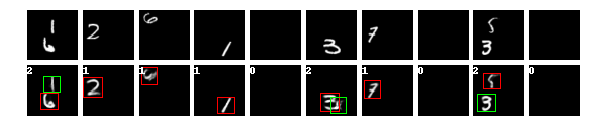

In [25]:
params = { 'figure.figsize': [8, 1.6] }   
plt.rcParams.update(params)
f, axarr = plt.subplots(2,n_images)

for i in range(n_images):
    img = arr2img(examples_to_viz[i].data.numpy()).convert('RGB')
    axarr[0,i].imshow(img)
    axarr[0,i].axis('off')

# run the guide and store the sampled random variables in the trace
trace = poutine.trace(air.guide).get_trace(examples_to_viz, None)
# run the prior against the samples in the trace
z, recons = poutine.replay(air.prior, trace)(examples_to_viz.size(0))
# extract the sampled random variables needed to generate the visualization
z_wheres = tensor_to_objs(latents_to_tensor(z))
# make the visualization
recon_imgs = draw_many(recons, z_wheres)
    
for i in range(n_images):
    axarr[1,i].imshow(recon_imgs[i])
    axarr[1,i].axis('off')

plt.subplots_adjust(left=0.02, bottom=0.04, right=0.98, top=0.96, wspace=0.1, hspace=0.1)
plt.savefig('air_multi_mnist_recons.png', dpi=400)
plt.show()

The images in the top row are from the test set; the corresponding reconstructions are in the bottom row.
Note that the small digits at the top left of each reconstructed image show the total number of objects used in the reconstruction, while the colored boxes denote the image patches used (i.e. the positions of each reconstructed object).

For a more a complete implementation with results please see the [tutorial](http://pyro.ai/examples/air.html).

## Pyro links

[Pyro website](http://pyro.ai)<br>
[VAE tutorial](http://pyro.ai/examples/vae.html)<br>
[AIR tutorial](http://pyro.ai/examples/air.html)<br>
[Documentation](http://docs.pyro.ai)<br>
[Pyro GitHub](http://github.com/uber/pyro)<br>
[Pyro Forum](http://forum.pyro.ai)

## References

[1] `Auto-Encoding Variational Bayes`,<br/>&nbsp;&nbsp;&nbsp;&nbsp;
Diederik P Kingma, Max Welling

[2] `Stochastic Backpropagation and Approximate Inference in Deep Generative Models`,
<br/>&nbsp;&nbsp;&nbsp;&nbsp;
Danilo Jimenez Rezende, Shakir Mohamed, Daan Wierstra

[3] `Attend, Infer, Repeat: Fast Scene Understanding with Generative Models`
<br />&nbsp;&nbsp;&nbsp;&nbsp;
S. M. Ali Eslami and Nicolas Heess and Theophane Weber and Yuval Tassa and Koray Kavukcuoglu and Geoffrey E. Hinton

[4] `Spatial Transformer Networks`
<br />&nbsp;&nbsp;&nbsp;&nbsp;
Max Jaderberg and Karen Simonyan and Andrew Zisserman